# Trust Region Policy Optimization

## What is TRPO?

It is a policy gradient algorithm that uses the constraint of not changing the policy too much between update steps.

## Math behind the magic

Without going into the entire details, let us construct the update equation for TRPO by assuming the existence of a surrogate loss function. (For details on how to formulate this surrogate, take a look at the refernces)

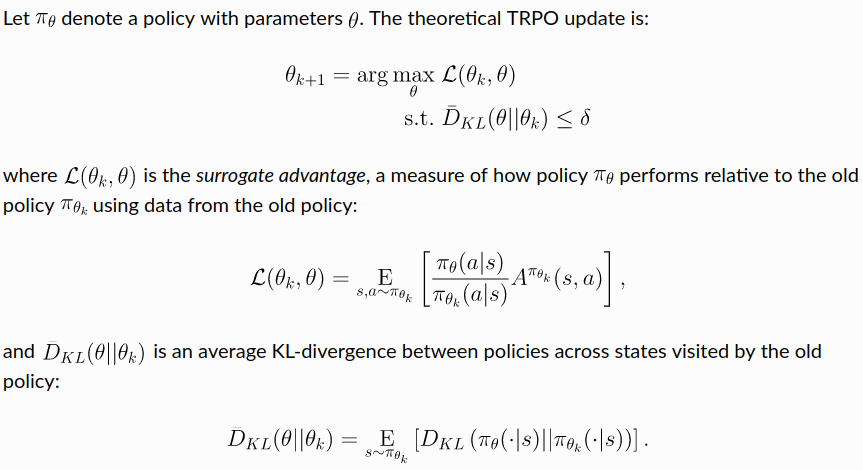

By making a linear approximation to the surrogate advantage and a quadratic approximation to the KL-Divergence constraint, the following update rule is obtained : 

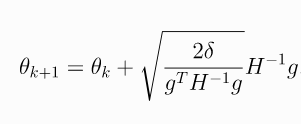

## The Algorithm

The derivation of the overall algorithm is quite math intensive and so is left to the reader to explore. The crux can be seen in the following lines : 

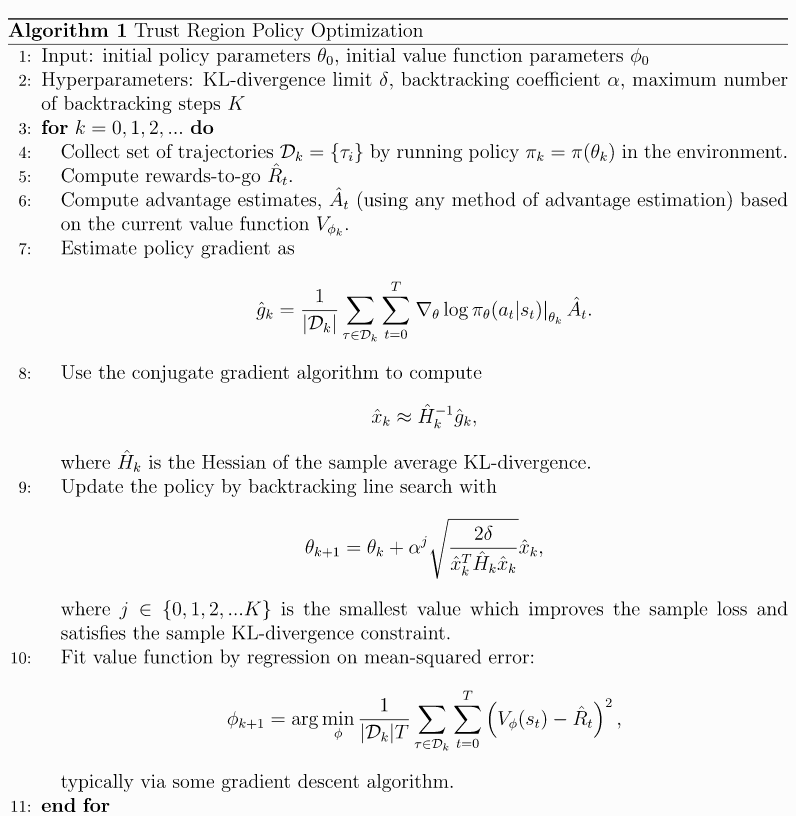

In [1]:
# Activate the environment and load the packages
using Pkg
Pkg.activate(".")

using Flux
using Gym
import Reinforce.action
import Reinforce:run_episode
import Flux.params
using Flux.Tracker: grad, update!
using Flux: onehot
using Statistics
using Distributed
using Distributions
using LinearAlgebra
using Base.Iterators
using Random
using BSON
using BSON:@save,@load
using JLD

In [2]:
# Import helper functions

# The number of parallel actors that collect trajectories of experiences
num_processes = 1 # Let's keep it to just one actor for now
include("../common/policies.jl")
include("../common/utils.jl")
include("../common/buffer.jl")
include("rollout.jl")
include("trpo_utils.jl")

conjugate_gradients (generic function with 3 methods)

In [15]:
# Functions to initialize buffers to log trajectory information and data for logging performance
function initialize_episode_buffer()
    eb = Buffer()
    register(eb,"states")
    register(eb,"actions")
    register(eb,"rewards")
    register(eb,"next_states")
    register(eb,"dones")
    register(eb,"returns")
    register(eb,"advantages")
    register(eb,"log_probs")
    register(eb,"kl_params")
    
    return eb
end

function initialize_stats_buffer()
    sb = Buffer()
    register(sb,"rollout_returns")
    
    return sb
end

initialize_stats_buffer (generic function with 1 method)

In [16]:
# Function to automatically select a policy given the environment
function get_policy(env_wrap::EnvWrap)
    if typeof(env_wrap.env._env.action_space) <: Gym.Space.Discrete
        return CategoricalPolicy(env_wrap)
    elseif typeof(env_wrap.env._env.action_space) <: Gym.Space.Box
        return DiagonalGaussianPolicy(env_wrap)
    else
        error("Policy type not supported")
    end
end

get_policy (generic function with 1 method)

In [17]:
# ----------------Hyperparameters----------------#
# Environment Variables #
# NOTE : TRPO will not work with Categorical Policies as nested AD is not currently defined for `softmax`
ENV_NAME = "Pendulum-v0"
EPISODE_LENGTH = 1000
terminate_horizon = false
resume = false
# Policy parameters #
η = 1e-3 # Learning rate
STD = 0.0 # Standard deviation
# GAE parameters
γ = 0.99
λ = 0.95
# Optimization parameters
δ = 0.01 # KL-Divergence constraint
V_ITERS = 5 # Number of iterations to train the value function network
NUM_EPISODES = 100000
BATCH_SIZE = 256
# FREQUENCIES
SAVE_FREQUENCY = 25
VERBOSE_FREQUENCY = 5
global_step = 0

# Define policy
env_wrap = EnvWrap(ENV_NAME)

if resume == true
    policy = load_policy(env_wrap,"../weights/")
else
    policy = get_policy(env_wrap)
end

# Define buffers
episode_buffer = initialize_episode_buffer()
stats_buffer = initialize_stats_buffer()

# Define optimizer for optimizing value function neural network
opt_value = ADAM(η)

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

## Writing the Loss function

The first part is simply the kl-divergence between the old and the new policy.

The kl-divergence for different policy types is already defined inside of `policies.jl`. In order to obtain it, you need to pass the current policy instance, `kl_vars` which are the populated kl-divergence related variables from the rollout and the current states for which the evaluation is to be done.

In [18]:
"""
For details on the kl_divergence function see `common/olicies.jl`
"""
function kl_loss(policy,states::Array,kl_vars)
    return mean(kl_divergence(policy,kl_vars,states))
end

kl_loss

The policy loss is the surrogate advantage : 

In [19]:
function policy_loss(policy,states::Array,actions::Array,advantages::Array,old_log_probs::Array)
    # Surrogate loss computation
    new_log_probs = log_prob(policy,states,actions)

    ratio = exp.(new_log_probs .- old_log_probs) # π_θ(a|s) / π_θₖ(a|s)
    π_loss = mean(ratio .* advantages)
    π_loss
end

policy_loss (generic function with 1 method)

The value loss is the squared difference betweeen the returns and the value estimates : 

In [20]:
function value_loss(policy,states::Array,returns::Array)
    return mean((policy.value_net(states) .- returns).^2) # ||V_ϕ(s_t) - Σγᵗr_t||²
end

value_loss (generic function with 1 method)

## Computing $H^{-1}g$

This part uses a nifty algebra trick. Firstly, instead of computing $H^{-1}g$, we compute $Hx = g$ by solving for x using the conjugate gradient algorithm and use that value.

Now, H is the hessian of the KL-Divergence between the old and new policies. Obtaining the hessian with respect to each parameter would slow down the computation and so a neat trick can be used herein.

Consider $Hx \space = \space \nabla^2D_{KL}(\theta || \theta_k) * x$

Let the size of the parameter space be $N$. Then H is a $NxN$ matrix and x is a $Nx1$ vector

$=> \space (Hx)_i \space = \Sigma_{j=1}^N\nabla_i\nabla_jD_{KL} * x_j$

$=> \space \nabla_i\Sigma_{j=1}^N(\nabla_jD_{KL}) * x_j$

Thus we first compute the gradient of the KL-divergence with respect to the policy parameters, then take a dot product with $x$ and again take the gradient of this vector product to obtain the hessain vector product.

The meat of the detail is outlined in the impelementation below which is also a part of `trpo_utils.jl`.

In [21]:
function gvp(policy,states,kl_vars,x)
    """
    Intermediate utility function, calculates Σ∇D_kl*x
    
    x : Variable to be estimated using conjugate gradient (Hx = g); (NUM_PARAMS,1)
    """
    model_params = get_policy_params(policy)
    gs = Tracker.gradient(() -> kl_loss(policy,states,kl_vars),model_params;nest=true)

    flat_grads = get_flat_grads(gs,get_policy_net(policy))
    return sum(x' * flat_grads)
end

function Hvp(policy,states,kl_vars,x;damping_coeff=0.1)
    """
    Computes the Hessian Vector Product
    Hessian is that of the kl divergence between the old and the new policies wrt the policy parameters
    
    Returns : Hx; H = ∇²D_kl
    """
    model_params = get_policy_params(policy)
    hessian = Tracker.gradient(() -> gvp(policy,states,kl_vars,x),model_params)
    return get_flat_grads(hessian,get_policy_net(policy)) # .+ (damping_coeff .* x)
end

Hvp (generic function with 1 method)

In [22]:
# Having all the things in place, find the right fraction of the optimal step size to update the parameters
# This is required to account for the errors introduced due to the approximation of the surrogate and constraint
function linesearch(policy,step_dir,states,actions,advantages,old_log_probs,kl_vars,old_params,num_steps=10;α=0.5)
    old_loss = policy_loss(policy,states,actions,advantages,old_log_probs).data

    for i in 1:num_steps
        # Obtain new parameters
        new_params = old_params .+ ((α^i) .* step_dir)

        # Set the new parameters to the policy
        set_flat_params(new_params,get_policy_net(policy))

        # Compute surrogate loss
        new_loss = policy_loss(policy,states,actions,advantages,old_log_probs).data
        
        # Compute kl divergence
        kl_div = kl_loss(policy,states,kl_vars).data

        if new_loss >= old_loss && (kl_div <= δ)
            println("---Success---")
            set_flat_params(new_params,get_policy_net(policy))
        return nothing
        end
    end
    
    set_flat_params(old_params,get_policy_net(policy))
end

linesearch (generic function with 2 methods)

In [27]:
function trpo_update(policy,states,actions,advantages,returns,log_probs,kl_vars,old_params)
    model_params = get_policy_params(policy)
    policy_grads = Tracker.gradient(() -> policy_loss(policy,states,actions,advantages,log_probs),model_params)
    flat_policy_grads = get_flat_grads(policy_grads,get_policy_net(policy)).data

    x = conjugate_gradients(policy,states,kl_vars,Hvp,flat_policy_grads,10)
    
    step_dir = nothing
    try
        step_dir = sqrt.((2 * δ) ./ (x' * Hvp(policy,states,kl_vars,x))) .* x
    catch
        # Unforseen circumstances
        println("Square root of a negative number received...Skipping update")
    return
    end
     
    # Do a line search and update the parameters
    linesearch(policy,step_dir,states,actions,advantages,log_probs,kl_vars,old_params)
    
    # Update value function
    for _ in 1:V_ITERS
        value_params = get_value_params(policy)
        gs = Tracker.gradient(() -> value_loss(policy,states,returns),value_params)
        update!(opt_value,value_params,gs)
    end
end


trpo_update (generic function with 1 method)

In [28]:
function train_step() 
    clear(episode_buffer)
    collect_and_process_rollouts(policy,episode_buffer,EPISODE_LENGTH,stats_buffer)
    
    idxs = partition(shuffle(1:size(episode_buffer.exp_dict["states"])[end]),BATCH_SIZE)
    
    old_params = copy(get_flat_params(get_policy_net(policy)))

    for i in idxs
        # println("A")
        mb_states = episode_buffer.exp_dict["states"][:,i] 
        mb_actions = episode_buffer.exp_dict["actions"][:,i] 
        mb_advantages = episode_buffer.exp_dict["advantages"][:,i] 
        mb_returns = episode_buffer.exp_dict["returns"][:,i] 
        mb_log_probs = episode_buffer.exp_dict["log_probs"][:,i]
        mb_kl_vars = episode_buffer.exp_dict["kl_params"][i]
        
        trpo_update(policy,mb_states,mb_actions,mb_advantages,mb_returns,mb_log_probs,mb_kl_vars,old_params)
    end
end

train_step (generic function with 1 method)

In [29]:
function train()
    for i in 1:NUM_EPISODES
        println(i)
        train_step()
        println(mean(stats_buffer.exp_dict["rollout_returns"]))

        if i % SAVE_FREQUENCY == 0
            save_policy(policy,"../weights")
        end
    end
end

train (generic function with 1 method)

In [32]:
# The mean of the total returns of a rollout are printed here which should generally increase with time
train()

1


InterruptException: InterruptException:

# Test the Policy

In [35]:
using OpenAIGym

ENV_NAME = "Pendulum-v0"
TEST_STEPS = 10000
global steps_run = 0

# Pass path where weights are saved
LOAD_PATH = "../weights/trpo/Pendulum-v0/"

# Define policy
env_wrap = EnvWrap(ENV_NAME)

# NOTE : An environment instance of OpenAIGym.jl is used here for the time being as rendering has a bug in Gym.jl
# env = make(ENV_NAME,:rgb)
# env.max_episode_steps = TEST_STEPS
env = GymEnv(ENV_NAME)
env.pyenv._max_episode_steps = TEST_STEPS
policy = load_policy(env_wrap,LOAD_PATH)

# Test Run Function
function test_run(env)
    global steps_run
    # testmode!(env)
    ep_r = 0.0
    
    s = OpenAIGym.reset!(env)
    println(s)
    for i in 1:TEST_STEPS
        if i % 1000 == 0
            println("---Resetting---")
            s = OpenAIGym.reset!(env)
            println(s)
            ep_r = 0.0
        end
        
        OpenAIGym.render(env)
        a = test_action(policy,s)
        a = convert.(Float64,a)

        if typeof(policy) <: DiagonalGaussianPolicy
            a = reshape(a,env_wrap.ACTION_SIZE)
        else
            # OpanAIGym hack
            a = a - 1.0f0
            a = Int64.(a)
        end

        # a = action(policy,s)
        # s_,r,_ = step!(env,a)
        r,s_ = OpenAIGym.step!(env,a)
        println(a)
        sleep(0.01)

        ep_r += r
        
        steps_run += 1
        
        s = s_
        if env.done
           # break 
           println("---Resetting---")
           s = OpenAIGym.reset!(env)
           println(ep_r)
           ep_r = 0.0
           continue
        end
    end
    ep_r
end

total_reward = test_run(env)

println("TOTAL STEPS :: $steps_run :: TOTAL REWARD :: $total_reward")

Loaded
[-0.860726, 0.509068, 0.165189]


┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = #render#3(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::GymEnv{PyCall.PyArray{Float64,1}}) at OpenAIGym.jl:81
└ @ OpenAIGym /home/shreyas/.julia/packages/OpenAIGym/wZkkM/src/OpenAIGym.jl:81


[-1.99198]
[-1.99014]
[-1.98741]
[-1.98345]
[-1.97785]
[-1.9702]
[-1.9601]
[-1.94738]
[-1.93222]
[-1.91525]
[-1.89757]
[-1.88064]
[-1.86613]
[-1.85559]
[-1.85032]
[-1.85109]
[-1.85794]
[-1.87011]
[-1.88607]
[-1.90389]
[-1.92169]
[-1.93802]
[-1.95202]
[-1.96343]
[-1.97238]
[-1.97918]
[-1.98423]
[-1.98791]
[-1.99053]
[-1.99234]
[-1.99355]
[-1.99427]
[-1.9946]
[-1.99457]
[-1.99417]
[-1.99334]
[-1.99194]
[-1.98976]
[-1.98648]
[-1.98169]
[-1.97486]
[-1.96544]
[-1.95299]
[-1.93734]
[-1.91882]
[-1.89834]
[-1.87738]
[-1.85781]
[-1.84161]
[-1.83064]
[-1.82636]
[-1.82953]
[-1.83994]
[-1.85636]
[-1.87665]
[-1.89831]
[-1.91911]
[-1.93748]
[-1.95271]
[-1.96474]
[-1.97391]
[-1.9807]
[-1.98564]
[-1.98915]
[-1.99161]
[-1.99327]
[-1.99434]
[-1.99496]
[-1.9952]
[-1.99509]
[-1.99461]
[-1.99367]
[-1.99211]
[-1.98965]
[-1.98591]
[-1.98033]
[-1.97224]
[-1.96091]
[-1.94577]
[-1.92662]
[-1.90389]
[-1.87878]
[-1.85319]
[-1.82946]
[-1.81005]
[-1.79726]
[-1.79289]
[-1.79788]
[-1.81193]
[-1.8333]
[-1.85909]
[-1.8

[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663167]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663168]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663164]
[-0.0663165]


InterruptException: InterruptException:

# Conclusion

The above explanation is very breif and is not into much of detail. You can go through the further readings below to understand the math and intricacies in detail.

# References

TRPO Paper : https://arxiv.org/abs/1502.05477

Spinning up Documentation : https://spinningup.openai.com/en/latest/algorithms/trpo.html

# Additional Reading

Deep RL by Berkeley : http://rail.eecs.berkeley.edu/deeprlcourse-fa18/static/slides/lec-9.pdf